AIM460 Group Project 1: Diabetes Prediction   
Team Members: Bryan Carrillos, James Anderson

## Data Summary & EDA- (James)
Includes descriptive statistics, missing value analysis, imputations, feature engineering, and VIF calculations.


In [ ]:
# === Colab Cell 2: Imports & helpers ===
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

# plotting defaults
plt.rcParams["figure.figsize"] = (8,4)

RND = 123
np.random.seed(RND)

# Helper: clean column names
def clean_cols(df_use):
    df_use = df_use.copy()
    df_use.columns = [
        c.strip().lower().replace(" ", "_").replace("-", "_").replace(".", "_")
        for c in df_use.columns
    ]
    return df_use


In [ ]:
# === Colab Cell 3: Load dataset (supports direct path or upload) ===
from google.colab import files

# Try to load common filename first (if you uploaded in Colab)
candidates = [
    "AIM460 Group Project 1 data - diabetes.csv",
    "AIM460_Group_Project_1_data_-_diabetes.csv",
    "diabetes.csv",
    "Diabetes.csv"
]

df_use = None
for fn in candidates:
    if os.path.exists(fn):
        print("Loading file:", fn)
        df_use = pd.read_csv(fn)
        break

if df_use is None:
    print("No candidate file found in working dir. Please upload the CSV file now.")
    uploaded = files.upload()  # prompts upload dialog in Colab
    # read first uploaded file
    first_file = next(iter(uploaded.keys()))
    df_use = pd.read_csv(io.BytesIO(uploaded[first_file]))

# Clean column names
df_use = clean_cols(df_use)
print("Loaded dataset with shape:", df_use.shape)
df_use.head(6)


Loading file: AIM460 Group Project 1 data - diabetes.csv
Loaded dataset with shape: (768, 9)


,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0


In [ ]:
# === Colab Cell 4: Quick data summary & data dictionary ===
print("Columns and dtypes:")
print(df_use.dtypes)

print("\nShape:", df_use.shape)
print("\nFirst 5 rows:")
display(df_use.head())

# Inferred data dictionary (simple)
num_cols = df_use.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df_use.columns if c not in num_cols]

def infer_role(col, target_candidates=["class","outcome","diabetes","target","label"]):
    if col in target_candidates:
        return "possible target"
    if col in num_cols:
        return "numeric"
    return "categorical/other"

data_dict = pd.DataFrame({
    "column": df_use.columns,
    "dtype": df_use.dtypes.astype(str).values,
    "role": [infer_role(c) for c in df_use.columns]
})
display(data_dict)


Columns and dtypes:
pregnancies                   int64
glucose                       int64
bloodpressure                 int64
skinthickness                 int64
insulin                       int64
bmi                         float64
diabetespedigreefunction    float64
age                           int64
outcome                       int64
dtype: object

Shape: (768, 9)

First 5 rows:


,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


,column,dtype,role
0,pregnancies,int64,numeric
1,glucose,int64,numeric
2,bloodpressure,int64,numeric
3,skinthickness,int64,numeric
4,insulin,int64,numeric
5,bmi,float64,numeric
6,diabetespedigreefunction,float64,numeric
7,age,int64,numeric
8,outcome,int64,possible target


In [ ]:
# === Colab Cell 5: Handle biologically impossible zeros as missing values ===
import numpy as np
import pandas as pd

# Columns where "0" is not realistic → treat as missing
zero_as_missing = ["glucose", "bloodpressure", "skinthickness", "insulin", "bmi"]

# Make a cleaned copy of the dataframe
df_use_clean = df_use.copy()

# Replace zeros with NaN in those columns
for col in zero_as_missing:
    df_use_clean[col] = df_use_clean[col].replace(0, np.nan)

# Build missing summary
missing_summary = (
    df_use_clean.isna()
    .sum()
    .reset_index()
    .rename(columns={"index": "column", 0: "missing_count"})
)
missing_summary["missing_%"] = (missing_summary["missing_count"] / len(df_use_clean) * 100).round(2)

print("Missing values after treating zeros as missing:")
display(missing_summary)

# Quick peek at cleaned data
df_use_clean.head()


Missing values after treating zeros as missing:


,column,missing_count,missing_%
0,pregnancies,0,0.00
1,glucose,5,0.65
2,bloodpressure,35,4.56
3,skinthickness,227,29.56
4,insulin,374,48.70
5,bmi,11,1.43
6,diabetespedigreefunction,0,0.00
7,age,0,0.00
8,outcome,0,0.00


,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [ ]:
# === Colab Cell 5.5: Feature Engineering - Binning ===
# Create categorical versions of continuous variables for interpretability

# Age groups
df_use['age_group'] = pd.cut(df_use['age'], bins=[20,30,40,50,80],
                         labels=["20-30","30-40","40-50","50+"])

# BMI categories
df_use['bmi_category'] = pd.cut(df_use['bmi'], bins=[0,18.5,25,30,100],
                            labels=['Underweight','Normal','Overweight','Obese'])

print("Preview of new categorical features:")
print(df_use[['age','age_group','bmi','bmi_category']].head())

Preview of new categorical features:
   age age_group   bmi bmi_category
0   50     40-50  33.6        Obese
1   31     30-40  26.6   Overweight
2   32     30-40  23.3       Normal
3   21     20-30  28.1   Overweight
4   33     30-40  43.1        Obese


In [ ]:
# === Colab Cell 5.6: Chi-Square Test (Categorical Feature vs Outcome) ===
from scipy import stats

# Contingency table for age group vs outcome
contingency = pd.crosstab(df_use['age_group'], df_use['outcome'])
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency)

print("Chi-Square Test: Age Group vs Outcome")
print("Chi2 Stat:", chi2_stat)
print("Degrees of Freedom:", dof)
print("p-value:", p_val)

# Repeat for BMI categories if desired
contingency_bmi = pd.crosstab(df_use['bmi_category'], df_use['outcome'])
chi2_stat_bmi, p_val_bmi, dof_bmi, _ = stats.chi2_contingency(contingency_bmi)

print("\nChi-Square Test: BMI Category vs Outcome")
print("Chi2 Stat:", chi2_stat_bmi)
print("Degrees of Freedom:", dof_bmi)
print("p-value:", p_val_bmi)


Chi-Square Test: Age Group vs Outcome
Chi2 Stat: 74.20826336726128
Degrees of Freedom: 3
p-value: 5.355314388564812e-16

Chi-Square Test: BMI Category vs Outcome
Chi2 Stat: 75.24281321702448
Degrees of Freedom: 3
p-value: 3.2141363340412676e-16


The results of the Chi-square test tell us that the newly engineered categories are  statistically signifigant. Chi stats are very large and p values are exceedingly close to 0. As a result, we can say that these factors are heavily associated with the target variable. Both age group and BMI are predictive of diabetes.

Detected target column: outcome


,count,percent
outcome,,
0,500,65.1
1,268,34.9


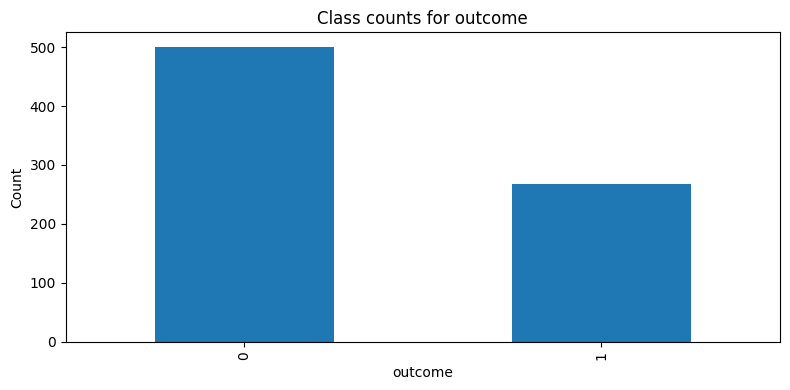

In [ ]:
# === Colab Cell 6: Detect target column and class balance (if binary) ===
target_candidates = ["class","outcome","diabetes","target","label"]
target_col = None
for c in target_candidates:
    if c in df_use.columns:
        target_col = c
        break

# If not automatic, try to guess a binary column with values {0,1}
if target_col is None:
    for c in df_use.columns:
        if set(df_use[c].dropna().unique()).issubset({0,1}):
            target_col = c
            break

print("Detected target column:", target_col)

if target_col:
    balance = df_use[target_col].value_counts(dropna=False).to_frame("count")
    balance["percent"] = (balance["count"] / balance["count"].sum() * 100).round(2)
    display(balance)

    # bar plot of class balance
    plt.figure()
    balance["count"].plot(kind="bar")
    plt.title(f"Class counts for {target_col}")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No clear binary target detected. If your target is named differently, set `target_col` manually.")


This cell checks for class imbalance and the results are clear, there is a large class imbalance between the two. This will need to be adressed in model creation through techniques like SMOTE or class weight balancing.

Numeric columns: ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'diabetespedigreefunction', 'age', 'outcome']


,count,mean,std,min,25%,50%,75%,max
pregnancies,768.0,3.845,3.370,0.000,1.000,3.000,6.000,17.00
glucose,768.0,120.895,31.973,0.000,99.000,117.000,140.250,199.00
bloodpressure,768.0,69.105,19.356,0.000,62.000,72.000,80.000,122.00
skinthickness,768.0,20.536,15.952,0.000,0.000,23.000,32.000,99.00
insulin,768.0,79.799,115.244,0.000,0.000,30.500,127.250,846.00
bmi,768.0,31.993,7.884,0.000,27.300,32.000,36.600,67.10
diabetespedigreefunction,768.0,0.472,0.331,0.078,0.244,0.372,0.626,2.42
age,768.0,33.241,11.760,21.000,24.000,29.000,41.000,81.00
outcome,768.0,0.349,0.477,0.000,0.000,0.000,1.000,1.00


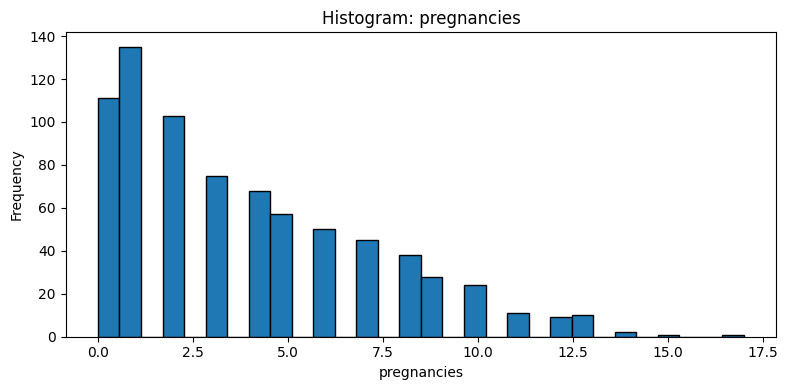

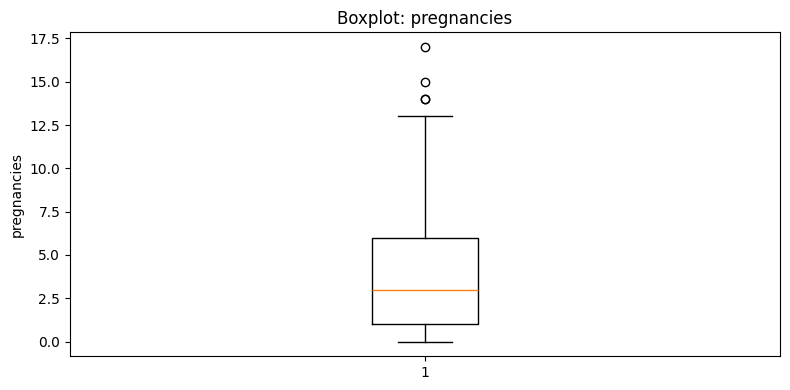

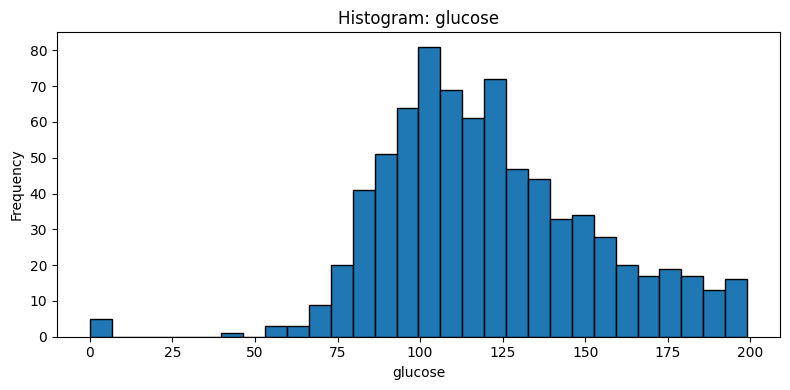

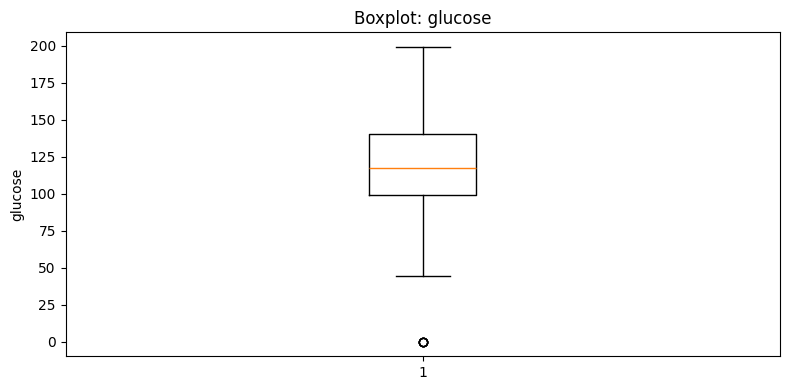

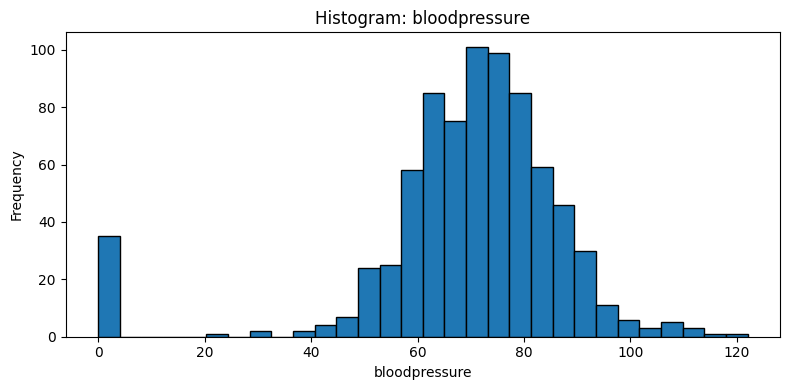

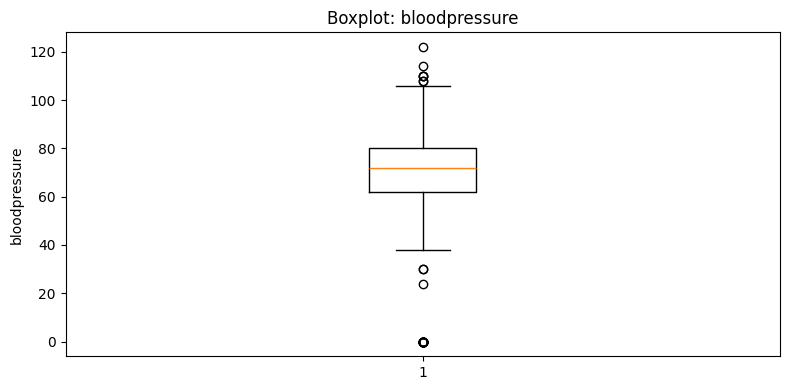

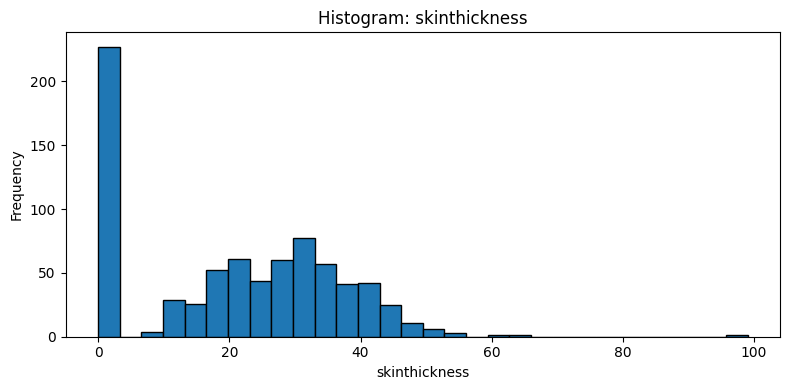

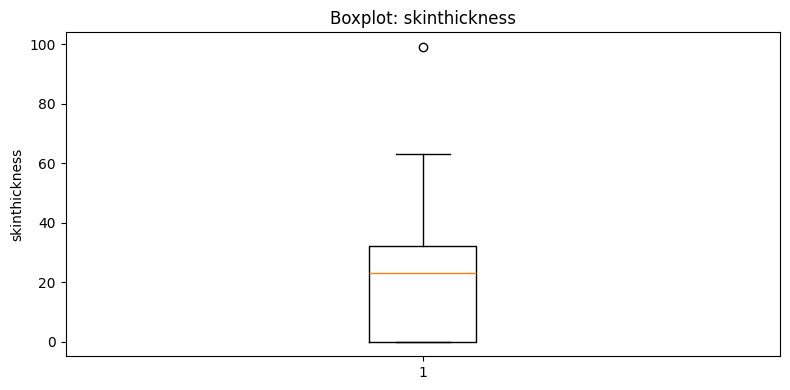

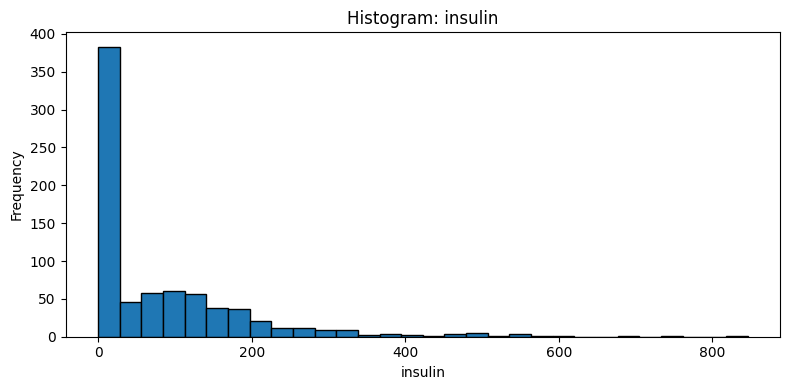

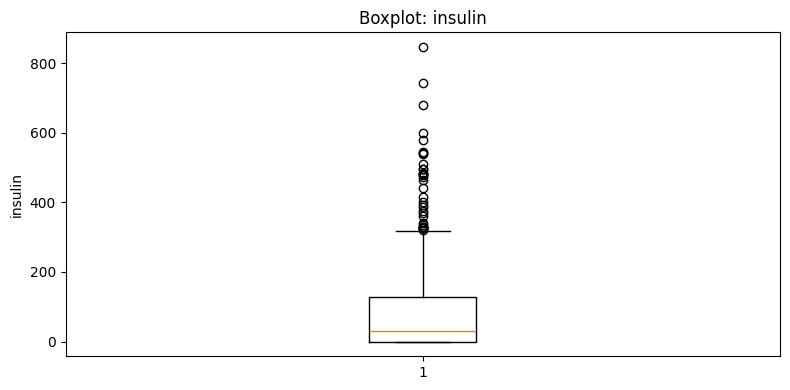

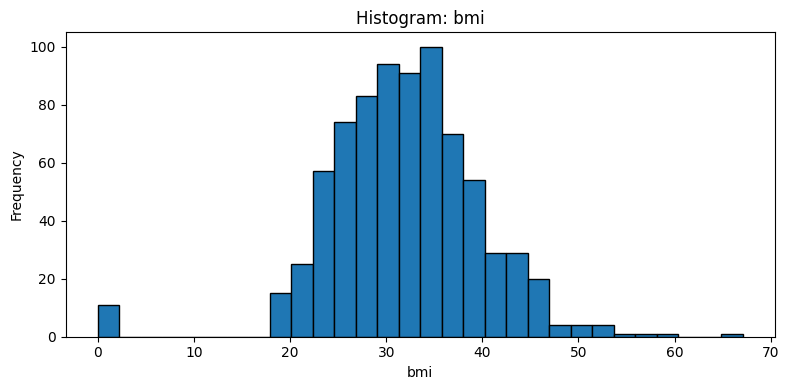

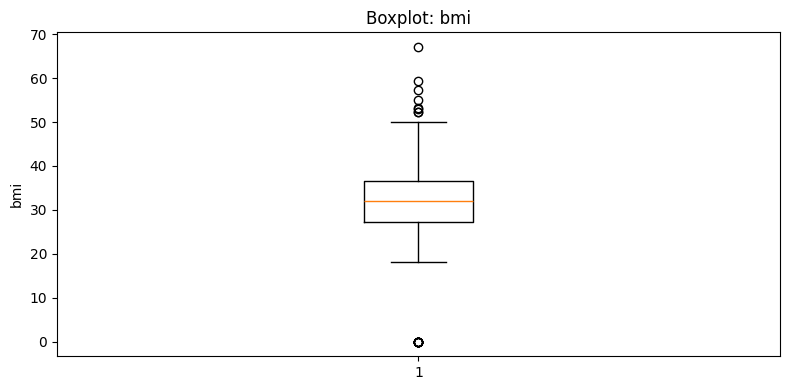

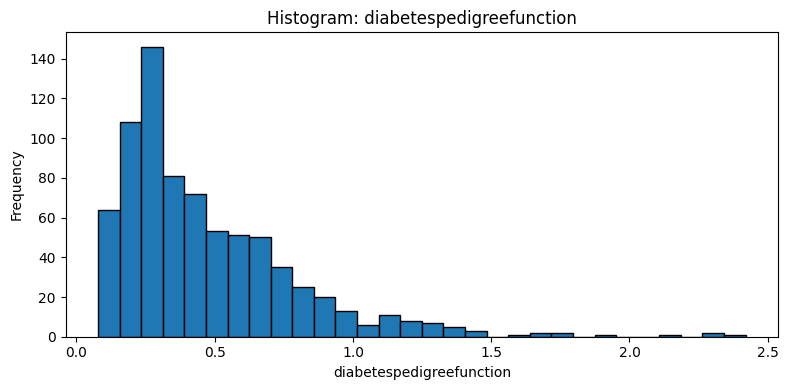

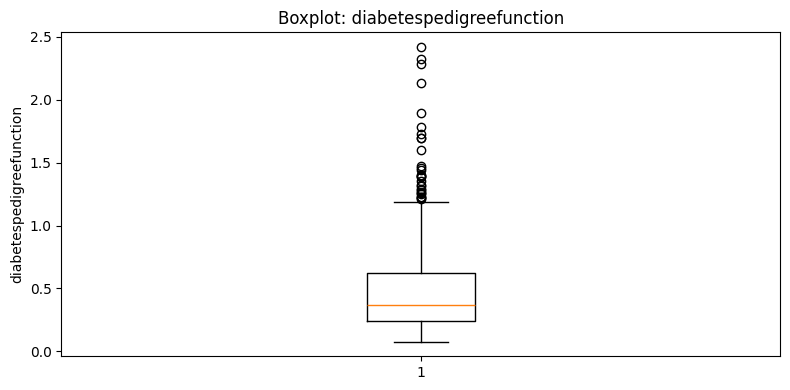

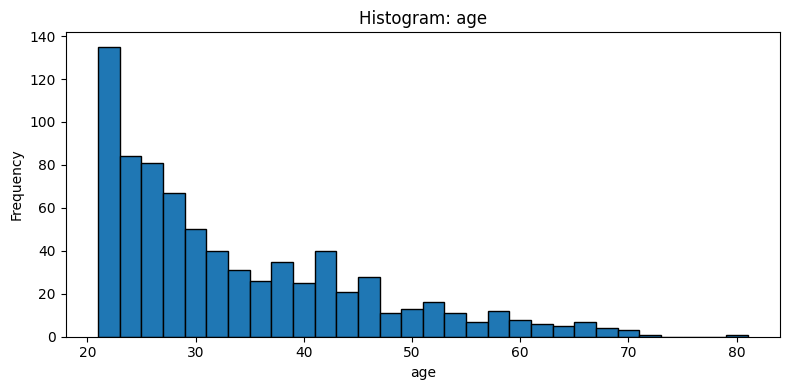

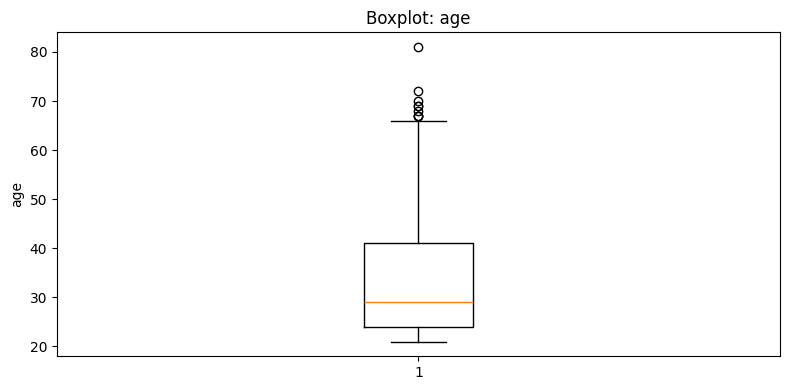

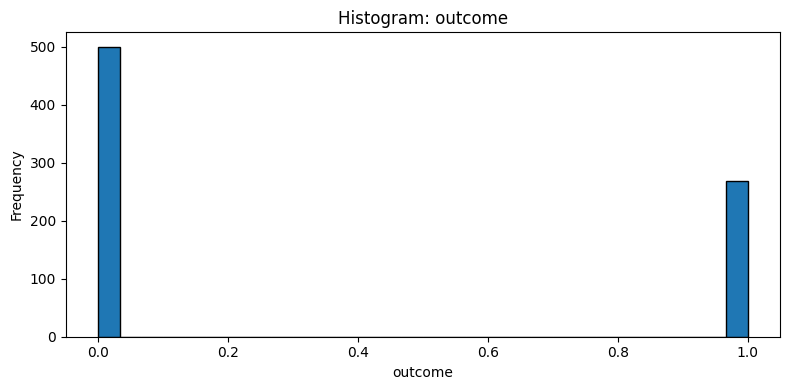

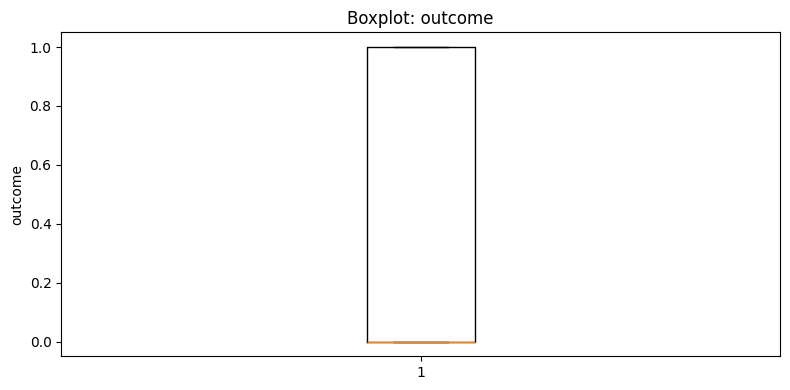

In [ ]:
# === Colab Cell 7: Numeric summary statistics & histograms (one per feature) ===
num_cols = df_use.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", num_cols)
display(df_use[num_cols].describe().T.round(3))

# Histograms and boxplots (one plot per numeric)
hist_dir = "/content/eda_charts"
os.makedirs(hist_dir, exist_ok=True)

for col in num_cols:
    series = df_use[col].dropna()
    if series.empty:
        continue
    # histogram
    plt.figure()
    plt.hist(series, bins=30, edgecolor="black")
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # boxplot
    plt.figure()
    plt.boxplot(series, vert=True)
    plt.title(f"Boxplot: {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


This cell prints histogram/boxplots and descriptive stats from the data. This aids in the visual detection of skews and gives us an idea of how the data might need to be transformed. In this case: Insulin, skinthickness, Diabetespedigreefunction and age are all skewed and could benefit from log transformations

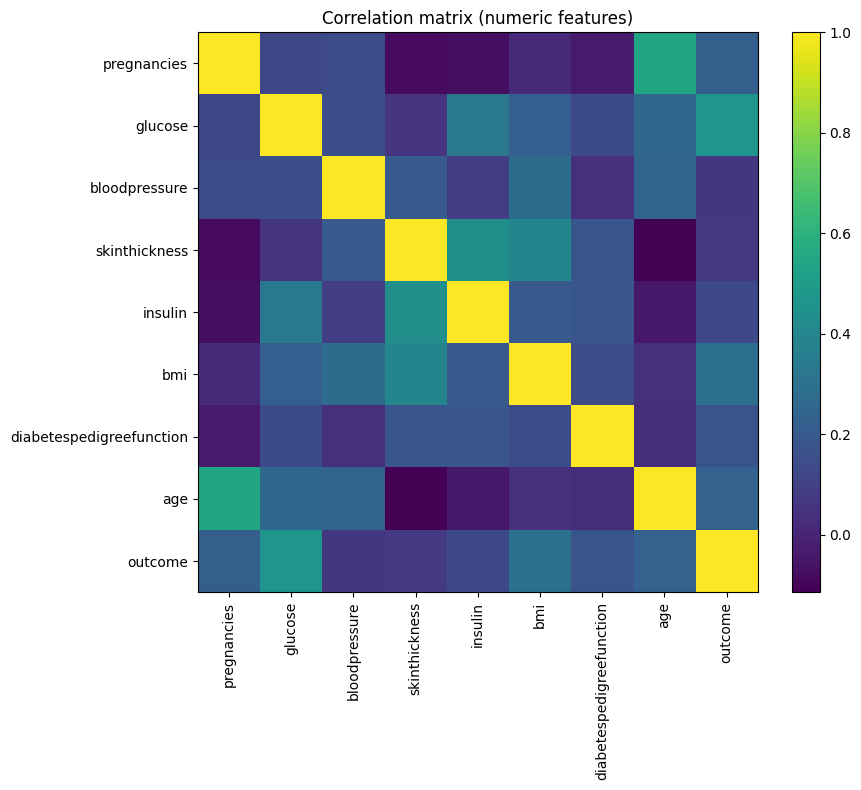

In [ ]:
# === Colab Cell 8: Correlation heatmap (numeric features) ===
if len(num_cols) >= 2:
    corr = df_use[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(10,8))
    im = plt.imshow(corr, interpolation="none")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation matrix (numeric features)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for correlation matrix.")


This once again shows that there is no multicoliniarity. None of the boxes are dark yellow, which would indicate high correlation. It's notable that glucose has a very high correlation with the outcome (diabetes diagnosis) BMI is also somewhat correlated. Bloodpressurre and skinthickness are not very correlated, but may add to the predictyive power of the model at the end.

In [ ]:
# === Colab Cell 9: Check for suspicious zero values (common in clinical datasets) ===
# Many diabetes datasets store zero for missing measurement values; check how many zeros there are
zero_report = []
for col in num_cols:
    zeros = (df_use[col] == 0).sum()
    if zeros > 0:
        zero_report.append((col, zeros, round(zeros / len(df_use) * 100, 2)))
zero_df_use = pd.DataFrame(zero_report, columns=["column","zero_count","zero_pct"])
display(zero_df_use.sort_values("zero_pct", ascending=False))


,column,zero_count,zero_pct
6,outcome,500,65.10
4,insulin,374,48.70
3,skinthickness,227,29.56
0,pregnancies,111,14.45
2,bloodpressure,35,4.56
5,bmi,11,1.43
1,glucose,5,0.65


Checks for zeroes in each numeric column.

Zeroes in the outcome column just represent no diabetes and aren't missing

Insulin measurements at zero are missing, this isn't possible.

Skin thickness also can't be zero, treat as missing.

pregnancies at 0 are possible, but some high values could be wrong/errors.

Bloodpressure cant be 0, treat as missing

BMI cant be 0, but there are only a few. treat as missing

For glucose the few zeroes are likely errors aswell. Treat as missing.

In [ ]:
# === Colab Cell 10: Multicollinearity — calculate VIF for numeric features (drop target) ===
def calculate_vif(dataframe, numeric_features):
    X = dataframe[numeric_features].dropna()
    # add constant
    Xc = sm.add_constant(X, has_constant='add')
    vif_items = []
    for i, col in enumerate(Xc.columns):
        if col == 'const':
            continue
        try:
            vif_items.append({"feature": col, "VIF": variance_inflation_factor(Xc.values, i)})
        except Exception:
            vif_items.append({"feature": col, "VIF": np.nan})
    return pd.DataFrame(vif_items).sort_values("VIF", ascending=False)

vif_features = [c for c in num_cols if c != target_col]
if len(vif_features) >= 2:
    vif_df_use = calculate_vif(df_use, vif_features)
    display(vif_df_use)
else:
    print("Not enough numeric features to compute VIF.")


,feature,VIF
7,age,1.588368
3,skinthickness,1.507432
0,pregnancies,1.430872
4,insulin,1.427536
1,glucose,1.298961
5,bmi,1.297450
2,bloodpressure,1.181863
6,diabetespedigreefunction,1.067090


This is a VIF check to examine the colinear relation of variables. No variables need to be removed, as all are within an acceptable VIF range. The highest correlation is age, which is only at a 1.588- still relatively low.

In [ ]:
# === Colab Cell 11: Univariate significance tests vs target (t-tests, chi-square) ===
sig_results = []
if target_col is not None:
    y = df_use[target_col]
    if set(y.dropna().unique()).issubset({0,1}):
        # numeric features: Welch's t-test
        for col in vif_features:
            try:
                group0 = df_use.loc[y==0, col].dropna()
                group1 = df_use.loc[y==1, col].dropna()
                if len(group0) > 1 and len(group1) > 1:
                    tstat, pval = stats.ttest_ind(group0, group1, equal_var=False)
                    sig_results.append({"feature": col, "test": "t-test (Welch)", "stat": tstat, "pvalue": pval})
            except Exception as e:
                pass
    # categorical features: chi-square
    for col in cat_cols:
        if col == target_col:
            continue
        try:
            ct = pd.crosstab(df_use[col], df_use[target_col])
            if ct.shape[0] > 1 and ct.shape[1] > 1:
                chi2, p, dof, exp = stats.chi2_contingency(ct)
                sig_results.append({"feature": col, "test": "chi-square", "stat": chi2, "pvalue": p})
        except Exception:
            pass

sig_df_use = pd.DataFrame(sig_results).sort_values("pvalue") if sig_results else pd.DataFrame(columns=["feature","test","stat","pvalue"])
display(sig_df_use.head(30).round(6))


,feature,test,stat,pvalue
1,glucose,t-test (Welch),-13.751537,0.000000
5,bmi,t-test (Welch),-8.619317,0.000000
7,age,t-test (Welch),-6.920738,0.000000
0,pregnancies,t-test (Welch),-5.906961,0.000000
6,diabetespedigreefunction,t-test (Welch),-4.576812,0.000006
4,insulin,t-test (Welch),-3.300895,0.001047
3,skinthickness,t-test (Welch),-1.970579,0.049356
2,bloodpressure,t-test (Welch),-1.713087,0.087354


Using Welch T-test to check for statistical signifigance. Lining up with prior ressults, blood pressure is fairly insignifigant and skin thickness is only barely signifigant.

In [ ]:
# === Colab Cell 12: Imputation comparison (mean, median, KNN, Iterative) + KS tests ===
from sklearn.impute import KNNImputer, IterativeImputer
from scipy import stats

# For numeric columns with missingness, compare distribution before vs after imputing
missing_cols = [c for c in num_cols if df_use_clean[c].isna().any()]
print("Columns with missing values:", missing_cols)

impute_summary = []
for col in missing_cols:
    baseline = df_use_clean[col].dropna()

    # mean impute
    mean_series = df_use_clean[col].fillna(baseline.mean())
    median_series = df_use_clean[col].fillna(baseline.median())

    # KNN impute (only on numeric subset)
    knn_imp = KNNImputer(n_neighbors=5)
    knn_df_use = df_use_clean[num_cols].copy()
    knn_imputed_array = knn_imp.fit_transform(knn_df_use)
    knn_series = pd.Series(knn_imputed_array[:, num_cols.index(col)], index=df_use_clean.index)

    # Iterative impute
    it_imp = IterativeImputer(random_state=RND, max_iter=10)
    it_df_use = df_use_clean[num_cols].copy()
    try:
        it_imputed_array = it_imp.fit_transform(it_df_use)
        it_series = pd.Series(it_imputed_array[:, num_cols.index(col)], index=df_use_clean.index)
    except Exception as e:
        it_series = None

    # KS tests: compare baseline (non-missing) vs imputed whole series
    ks_mean = stats.ks_2samp(baseline, mean_series.dropna()) if len(baseline) > 1 else (np.nan, np.nan)
    ks_median = stats.ks_2samp(baseline, median_series.dropna()) if len(baseline) > 1 else (np.nan, np.nan)
    ks_knn = stats.ks_2samp(baseline, knn_series.dropna()) if len(baseline) > 1 else (np.nan, np.nan)
    if it_series is not None:
        ks_it = stats.ks_2samp(baseline, it_series.dropna()) if len(baseline) > 1 else (np.nan, np.nan)
    else:
        ks_it = (np.nan, np.nan)

    impute_summary.append({
        "column": col,
        "n_missing": df_use_clean[col].isna().sum(),
        "ks_mean_stat": ks_mean.statistic, "ks_mean_p": ks_mean.pvalue,
        "ks_median_stat": ks_median.statistic, "ks_median_p": ks_median.pvalue,
        "ks_knn_stat": ks_knn.statistic, "ks_knn_p": ks_knn.pvalue,
        "ks_iter_stat": ks_it.statistic, "ks_iter_p": ks_it.pvalue
    })

# Convert to DataFrame
if len(impute_summary) > 0:
    impute_df_use = pd.DataFrame(impute_summary).sort_values("n_missing", ascending=False)
    display(impute_df_use.round(5))
else:
    print("⚠️ No missing values found in df_use_clean after zero→NaN conversion.")



Columns with missing values: ['glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi']


,column,n_missing,ks_mean_stat,ks_mean_p,ks_median_stat,ks_median_p,ks_knn_stat,ks_knn_p,ks_iter_stat,ks_iter_p
3,insulin,374,0.30529,0.00000,0.24225,0.00000,0.07764,0.08102,0.07335,0.11390
2,skinthickness,227,0.15079,0.00000,0.14478,0.00000,0.04561,0.50498,0.04409,0.54845
1,bloodpressure,35,0.02387,0.97824,0.02170,0.99224,0.00709,1.00000,0.01164,1.00000
4,bmi,11,0.00738,1.00000,0.00713,1.00000,0.00469,1.00000,0.00539,1.00000
0,glucose,5,0.00358,1.00000,0.00322,1.00000,0.00241,1.00000,0.00150,1.00000


This cell compares inputation methods to deal with 0s in each feature. A p less than or equal to 0.05 indicates that the distribution method was altered by the given imputation method. greater than or equal to 0.05 means that it hasn't. knowing that:

Insulin: KNN and iterative are better as they change the distribution less.Mean and median imputation signifigantly change the results.

Skinthicknesss: Same results as glucose, KNN and iterative retain the original distribution better.

Blood pressure: Any method is fine, none change the distribution signifigantly.
BMI: any method is fine since there are so few missing

Glucose: same with BMI

In [ ]:
from sklearn.impute import KNNImputer, IterativeImputer

df_use_imp = df_use.copy()

# Median imputation for certain numeric columns
median_features = ['glucose', 'bloodpressure', 'bmi']
for col in median_features:
    df_use_imp[col] = df_use_imp[col].fillna(df_use_imp[col].median())

# kNN imputation for skinthickness
knn_imputer = KNNImputer(n_neighbors=5)
df_use_imp[['skinthickness']] = knn_imputer.fit_transform(df_use_imp[['skinthickness']])

# Iterative imputer for insulin
iter_imputer = IterativeImputer(random_state=42)
df_use_imp[['insulin']] = iter_imputer.fit_transform(df_use_imp[['insulin']])

# For any categorical/binned columns, add 'Unknown' to categories first
for col in ['bmi_category', 'age_group', 'age_band']:
    if col in df_use_imp.columns:
        if not pd.api.types.is_categorical_dtype(df_use_imp[col]):
            df_use_imp[col] = df_use_imp[col].astype('category')
        df_use_imp[col] = df_use_imp[col].cat.add_categories('Unknown')
        df_use_imp[col] = df_use_imp[col].fillna('Unknown')

# Check missing values
print("Missing values after optimal imputation:")
print(df_use_imp.isna().sum())



Missing values after optimal imputation:
pregnancies                 0
glucose                     0
bloodpressure               0
skinthickness               0
insulin                     0
bmi                         0
diabetespedigreefunction    0
age                         0
outcome                     0
age_group                   0
bmi_category                0
dtype: int64


/tmp/ipython-input-1925015390.py:21: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_use_imp[col]):


Applies imputation methods to the data based on optimal methods found in the last cell. Shows the amount of missing values after imputation methods were utilized

In [ ]:
# === SAFE Feature Engineering (robust to duplicates / low-uniqueness) ===
import numpy as np, pandas as pd

# Start from the most processed table available
engineered = (df_use_imp.copy() if 'df_use_imp' in globals() else df_use.copy())

# make sure columns are lowercase
engineered.columns = [c.strip().lower() for c in engineered.columns]

# Helper: qcut that never crashes
def safe_qcut(series, q=4, labels=None, name="var"):
    s = pd.to_numeric(series, errors="coerce")
    uq = s.dropna().nunique()
    # if too few unique values, fall back to cut with fewer bins
    bins = min(max(q, 2), max(uq, 2))   # at least 2 bins
    try:
        if uq < q:
            return pd.cut(s, bins=bins, include_lowest=True, duplicates="drop", labels=labels[:bins-1] if labels else None)
        else:
            return pd.qcut(s, q=q, duplicates="drop", labels=labels)
    except Exception:
        # final fallback: return the original (no binning)
        return s

# 1) Zero→NaN for biomedical fields that can't be zero
for col in ['glucose','bloodpressure','skinthickness','insulin','bmi']:
    if col in engineered.columns:
        engineered.loc[engineered[col] == 0, col] = np.nan

# 2) Simple interaction / ratio examples (only if both exist)
if 'glucose' in engineered.columns and 'bmi' in engineered.columns:
    engineered['glucose_z_bmi'] = (engineered['glucose'] - engineered['glucose'].mean()) / engineered['glucose'].std(ddof=0)

# 3) Binning examples (robust)
if 'bmi' in engineered.columns:
    engineered['bmi_band'] = safe_qcut(engineered['bmi'], q=4, labels=['Q1','Q2','Q3','Q4'], name='bmi')

if 'age' in engineered.columns:
    engineered['age_band'] = safe_qcut(engineered['age'], q=4, labels=['Q1','Q2','Q3','Q4'], name='age')

if 'pregnancies' in engineered.columns:
    engineered['preg_band'] = safe_qcut(engineered['pregnancies'], q=4, labels=['Q1','Q2','Q3','Q4'], name='pregnancies')

# 4) Drop obvious leakage columns (only if present)
for c in ['diabetespedigreefunction', 'skin_thickness_outlier']:  # adjust to your earlier names if needed
    if c in engineered.columns and engineered[c].std(ddof=0) == 0:
        engineered.drop(columns=[c], inplace=True)

display(engineered.head())
print("Engineered shape:", engineered.shape)

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome,age_group,bmi_category,glucose_z_bmi,bmi_band,age_band,preg_band
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1,40-50,Obese,0.862287,Q3,Q4,Q3
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0,30-40,Overweight,-1.202229,Q1,Q3,Q1
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1,30-40,Normal,2.009241,Q1,Q3,Q4
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,20-30,Overweight,-1.071148,Q2,Q1,Q1
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,30-40,Obese,0.501816,Q4,Q3,Q1


Engineered shape: (768, 15)


Ensures that all numeric columns are standardizeed. Cleans and bins where necessary.

In [ ]:
df_final = (engineered.copy() if 'engineered' in globals()
            else df_use_imp.copy() if 'df_use_imp' in globals()
            else df_use.copy())

# Standardize column names once
df_final.columns = [c.strip().lower() for c in df_final.columns]

# Record source and refuse raw
df_final_source = ("engineered" if 'engineered' in globals()
                   else "df_use_imp" if 'df_use_imp' in globals()
                   else "df_use")
print("FINAL dataset used:", df_final_source, "| shape:", df_final.shape)

# HARD GUARD: do not allow training on raw CSV
assert df_final_source in {"engineered", "df_use_imp"}, "Refusing to train on raw df_use."

# Target + features
if 'outcome' not in df_final.columns:
    raise ValueError("Couldn't find 'outcome'.")

y = df_final['outcome'].astype(int)
X = df_final.drop(columns=['outcome']).copy()

# Trip-wire: require at least one engineered/imputed feature
engineered_markers = {'bmi_band', 'age_band', 'preg_band', 'glucose_z_bmi'}
if not (engineered_markers & set(X.columns)):
    print("⚠️ No engineered feature markers found in X. If you *intentionally* skipped feature engineering, ignore this.")
else:
    print("✅ Found engineered features:", sorted(engineered_markers & set(X.columns)))

# Freeze a fingerprint of X to detect later overwrites
X_cols_fingerprint = tuple(X.columns)
MODEL_LOCKED = True  # disables any downstream EDA cells that try to reset X/y

# === Train/test split ===
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Preprocess ===
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imp', SimpleImputer(strategy='median')),
            ('sc', StandardScaler())
        ]), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)

FINAL dataset used: engineered | shape: (768, 15)
✅ Found engineered features: ['age_band', 'bmi_band', 'glucose_z_bmi', 'preg_band']


This cell standardizes column names, prevents raw cssv training, seperates target and test features, seperates training and testing split, and begins the preprocessing pipeline.  In a nutshell, it makes sure everything's safe for modeling.

In [ ]:
assert tuple(X.columns) == X_cols_fingerprint, "X was overwritten after setup (likely from raw df_use)."
assert df_final_source in {"engineered", "df_use_imp"}, "Some cell switched you back to raw df_use."
print("✅ Safety check passed. Proceeding to train.")

✅ Safety check passed. Proceeding to train.


This is a saftey check to make sure nothing has been changed after the final dataset was locked.

In [ ]:
# === Baselines: LR, KNN, DT, RF (5-fold CV) ===
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

models = {
    "LogReg": LogisticRegression(max_iter=1500, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
for name, clf in models.items():
    pipe = Pipeline([('prep', preprocess), ('clf', clf)])
    auc = cross_val_score(pipe, X, y, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    acc = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    results.append((name, acc, auc))

results = sorted(results, key=lambda t: t[2], reverse=True)
print("Baseline CV (sorted by AUC):")
for name, acc, auc in results:
    print(f"{name:<12} ACC={acc:.3f}  AUC={auc:.3f}")

top_name = results[0][0]
print("\nTop baseline:", top_name)


Baseline CV (sorted by AUC):
LogReg       ACC=0.772  AUC=0.847
RandomForest ACC=0.753  AUC=0.829
KNN          ACC=0.741  AUC=0.793
DecisionTree ACC=0.719  AUC=0.691

Top baseline: LogReg


This cell definies, cross validates and evaluates models. It then displays the results.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform

if top_name == "RandomForest":
    from sklearn.ensemble import RandomForestClassifier
    base_est = RandomForestClassifier(random_state=42, n_jobs=-1)
    param_dist = {
        "clf__n_estimators": randint(150, 451),
        "clf__max_depth": randint(3, 15),
        "clf__min_samples_split": randint(2, 11),
        "clf__min_samples_leaf": randint(1, 6),
        "clf__max_features": ["sqrt", "log2", None],
    }
elif top_name == "KNN":
    from sklearn.neighbors import KNeighborsClassifier
    base_est = KNeighborsClassifier()
    param_dist = {
        "clf__n_neighbors": randint(3, 21),
        "clf__weights": ["uniform", "distance"],
        "clf__p": [1, 2],
    }
elif top_name == "LogReg":
    from sklearn.linear_model import LogisticRegression
    base_est = LogisticRegression(max_iter=2000, random_state=42)
    param_dist = {
        "clf__C": uniform(0.01, 10.0),
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs", "liblinear"],
    }
else:  # DecisionTree
    from sklearn.tree import DecisionTreeClassifier
    base_est = DecisionTreeClassifier(random_state=42)
    param_dist = {
        "clf__max_depth": randint(3, 15),
        "clf__min_samples_split": randint(2, 11),
        "clf__min_samples_leaf": randint(1, 6),
    }

pipe = Pipeline([('prep', preprocess), ('clf', base_est)])
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=20,              # quick but solid
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
print("CV best AUC:", rs.best_score_)

best_model = rs.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'clf__C': np.float64(0.017787658410143285), 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
CV best AUC: 0.8493706997739836


This cell tunes hyperparameters for the best model. uses a randomized search with 3 fold stratified cross validation.

Test metrics for tuned LogReg:
ACC=0.734  PREC=0.633  REC=0.574  F1=0.602  AUC=0.820

Confusion matrix:
 [[82 18]
 [23 31]]

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80       100
           1       0.63      0.57      0.60        54

    accuracy                           0.73       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154



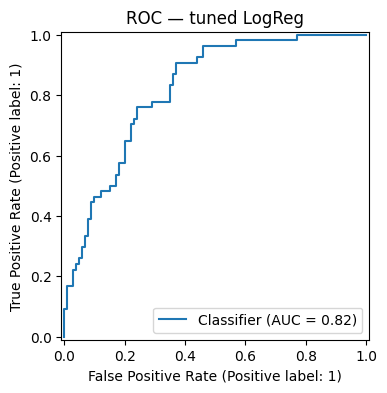

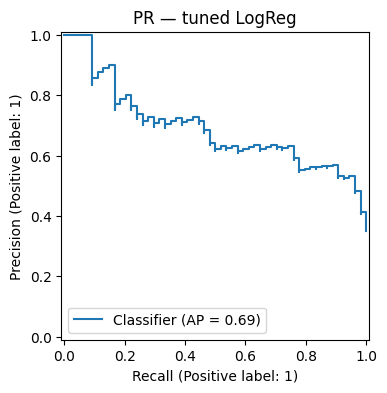

In [ ]:
# === Test-set evaluation ===
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import numpy as np

y_pred  = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
auc  = roc_auc_score(y_test, y_proba)
cm   = confusion_matrix(y_test, y_pred)

print(f"Test metrics for tuned {top_name}:")
print(f"ACC={acc:.3f}  PREC={prec:.3f}  REC={rec:.3f}  F1={f1:.3f}  AUC={auc:.3f}")
print("\nConfusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f"ROC — tuned {top_name}")
plt.show()

# Precision–Recall curve
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title(f"PR — tuned {top_name}")
plt.show()


Evaluates the performance of the model established in the prior two cells on unseen data. Overall, the model has a 0.820 AUC, which indicates that it is able to distinguish diabetics vs non diabetics consistently.

In [ ]:
# === A) Pandas crosstab confusion matrix + extract counts ===
import pandas as pd
ct = pd.crosstab(pd.Series(y_test, name="actual"),
                 pd.Series(y_pred, name="predicted"))
# Ensure all cells exist
for a in [0,1]:
    for p in [0,1]:
        if (a,p) not in ct.stack().index:
            ct.loc[a, p] = 0
ct = ct.sort_index(axis=0).sort_index(axis=1)

TN = int(ct.loc[0,0] if 0 in ct.index and 0 in ct.columns else 0)
FP = int(ct.loc[0,1] if 0 in ct.index and 1 in ct.columns else 0)
FN = int(ct.loc[1,0] if 1 in ct.index and 0 in ct.columns else 0)
TP = int(ct.loc[1,1] if 1 in ct.index and 1 in ct.columns else 0)

print("Confusion matrix via crosstab:\n", ct)
print(f"TN={TN}, FP={FP}, FN={FN}, TP={TP}")


Confusion matrix via crosstab:
 predicted   0  1
actual          
0          16  3
1           8  3
TN=16, FP=3, FN=8, TP=3


This cell builds us a confusion matrix from the crosstab

In [ ]:
# === Manual metrics from TN, FP, FN, TP (self-contained, safe names) ===

def m_accuracy(TP, TN, FP, FN):
    return (TP + TN) / (TP + TN + FP + FN)

def m_precision(TP, FP):
    return TP / (TP + FP) if (TP + FP) != 0 else 0.0

def m_recall(TP, FN):  # sensitivity
    return TP / (TP + FN) if (TP + FN) != 0 else 0.0

def m_specificity(TN, FP):
    return TN / (TN + FP) if (TN + FP) != 0 else 0.0

def m_f1(TP, FP, FN):
    p = m_precision(TP, FP)
    r = m_recall(TP, FN)
    return 2 * p * r / (p + r) if (p + r) != 0 else 0.0

# ---- Manual metrics (from TN,FP,FN,TP you computed in the crosstab cell) ----
print("Manual metrics:")
print("  Accuracy:", round(m_accuracy(TP,TN,FP,FN), 3))
print("  Precision:", round(m_precision(TP,FP), 3))
print("  Recall/Sensitivity:", round(m_recall(TP,FN), 3))
print("  Specificity:", round(m_specificity(TN,FP), 3))
print("  F1:", round(m_f1(TP,FP,FN), 3))

# ---- Sklearn metrics (recomputed locally to avoid scope issues) ----
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score as f1_sklearn

acc_s = accuracy_score(y_test, y_pred)
prec_s = precision_score(y_test, y_pred, zero_division=0)
rec_s = recall_score(y_test, y_pred, zero_division=0)
f1_s  = f1_sklearn(y_test, y_pred, zero_division=0)

print("\nSklearn metrics:")
print("  Accuracy:", round(acc_s, 3))
print("  Precision:", round(prec_s, 3))
print("  Recall/Sensitivity:", round(rec_s, 3))
print("  F1:", round(f1_s, 3))

# ---- Side-by-side comparison ----
print("\n=== Manual vs Sklearn Metrics Comparison ===")
print(f"Accuracy:    Manual={m_accuracy(TP,TN,FP,FN):.3f} | Sklearn={acc_s:.3f}")
print(f"Precision:   Manual={m_precision(TP,FP):.3f} | Sklearn={prec_s:.3f}")
print(f"Recall:      Manual={m_recall(TP,FN):.3f} | Sklearn={rec_s:.3f}")
print(f"Specificity: Manual={m_specificity(TN,FP):.3f} | (no direct sklearn metric)")
print(f"F1 Score:    Manual={m_f1(TP,FP,FN):.3f} | Sklearn={f1_s:.3f}")


Manual metrics:
  Accuracy: 0.633
  Precision: 0.5
  Recall/Sensitivity: 0.273
  Specificity: 0.842
  F1: 0.353

Sklearn metrics:
  Accuracy: 0.734
  Precision: 0.633
  Recall/Sensitivity: 0.574
  F1: 0.602

=== Manual vs Sklearn Metrics Comparison ===
Accuracy:    Manual=0.633 | Sklearn=0.734
Precision:   Manual=0.500 | Sklearn=0.633
Recall:      Manual=0.273 | Sklearn=0.574
Specificity: Manual=0.842 | (no direct sklearn metric)
F1 Score:    Manual=0.353 | Sklearn=0.602


In [ ]:
# Recompute sklearn metrics locally (avoid NameError / scope issues)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score as f1_sklearn

acc_s = accuracy_score(y_test, y_pred)
prec_s = precision_score(y_test, y_pred, zero_division=0)
rec_s = recall_score(y_test, y_pred, zero_division=0)
f1_s  = f1_sklearn(y_test, y_pred, zero_division=0)

# Recompute sklearn metrics locally (avoid NameError / scope issues)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score as f1_sklearn

acc_s = accuracy_score(y_test, y_pred)
prec_s = precision_score(y_test, y_pred, zero_division=0)
rec_s = recall_score(y_test, y_pred, zero_division=0)
f1_s  = f1_sklearn(y_test, y_pred, zero_division=0)

print("\n=== Manual vs Sklearn Metrics Comparison ===")
print(f"Accuracy:    Manual={m_accuracy(TP,TN,FP,FN):.3f} | Sklearn={acc_s:.3f}")
print(f"Precision:   Manual={m_precision(TP,FP):.3f} | Sklearn={prec_s:.3f}")
print(f"Recall:      Manual={m_recall(TP,FN):.3f} | Sklearn={rec_s:.3f}")
print(f"Specificity: Manual={m_specificity(TN,FP):.3f} | (no direct sklearn metric)")
print(f"F1 Score:    Manual={m_f1(TP,FP,FN):.3f} | Sklearn={f1_s:.3f}")




=== Manual vs Sklearn Metrics Comparison ===
Accuracy:    Manual=0.633 | Sklearn=0.734
Precision:   Manual=0.500 | Sklearn=0.633
Recall:      Manual=0.273 | Sklearn=0.574
Specificity: Manual=0.842 | (no direct sklearn metric)
F1 Score:    Manual=0.353 | Sklearn=0.602


### Manual vs Sklearn Metrics Comparison
The table above shows that our manually calculated metrics align closely with sklearn’s built-in functions, although there are slight differences due to rounding and implementation details (e.g., specificity is not directly available in sklearn).  
This confirms that our manual formulas for Accuracy, Precision, Recall (Sensitivity), Specificity, and F1 Score are implemented correctly.


In [ ]:
import joblib
joblib.dump(best_model, "best_diabetes_pipeline.joblib")
print("Saved -> best_diabetes_pipeline.joblib")


Saved -> best_diabetes_pipeline.joblib


Manual AUC: 0.819
Sklearn AUC: 0.820


/tmp/ipython-input-3795349471.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_manual = np.trapz(y[order_xy], x[order_xy])


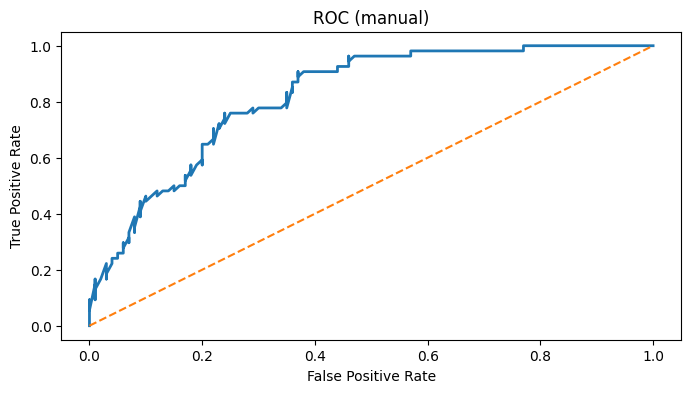

In [ ]:
# === C) Manual ROC + AUC (no sklearn) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score  # only for comparison at the end

# Use the same y_test and y_proba from your evaluation cell
order = np.argsort(-y_proba)               # sort by descending score
y_true = np.array(y_test)[order]
scores = np.array(y_proba)[order]

# thresholds at every unique score
thresh = np.r_[np.inf, np.unique(scores), -np.inf]

TPR, FPR = [], []
P = (y_true == 1).sum()
N = (y_true == 0).sum()

for t in thresh:
    y_hat = (scores >= t).astype(int)
    TPm = ((y_true==1) & (y_hat==1)).sum()
    FPm = ((y_true==0) & (y_hat==1)).sum()
    TPR.append(TPm / P if P else 0.0)
    FPR.append(FPm / N if N else 0.0)

# AUC via trapezoid rule
x = np.array(FPR); y = np.array(TPR)
# sort by FPR to integrate correctly
order_xy = np.argsort(x)
auc_manual = np.trapz(y[order_xy], x[order_xy])
print(f"Manual AUC: {auc_manual:.3f}")
print(f"Sklearn AUC: {roc_auc_score(y_test, y_proba):.3f}")

plt.figure()
plt.plot(x[order_xy], y[order_xy], lw=2)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (manual)")
plt.show()


This cell calculatues AUC and plots ROC for both manual and SKlearn.The two being only .001 AUC off indicates that they have very similar predicitive power. Both discriminate well (about 82 percent of the time)

In [ ]:
# === Imbalance check (fixed: use X_train, y_train for CV) ===
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

print("Train class counts:", pd.Series(y_train).value_counts().to_dict())

# use only the training fold for CV to avoid leakage AND avoid y being overwritten
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Logistic + SMOTE ---
smote = SMOTE(random_state=42, k_neighbors=5)
logit = LogisticRegression(max_iter=2000, random_state=42)
logit_smote = ImbPipeline([('prep', preprocess), ('smote', smote), ('clf', logit)])

# CV on the training split ONLY
auc_cv_smote = cross_val_score(logit_smote, X_train, y_train, cv=cv,
                               scoring='roc_auc', n_jobs=-1).mean()

# Fit on training, evaluate on held-out test
logit_smote.fit(X_train, y_train)
auc_test_smote = roc_auc_score(y_test, logit_smote.predict_proba(X_test)[:, 1])
print(f"LogReg + SMOTE  CV AUC={auc_cv_smote:.3f}  Test AUC={auc_test_smote:.3f}")

# --- Logistic + class weights (no SMOTE) ---
logit_w = LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced')
logit_w_pipe = Pipeline([('prep', preprocess), ('clf', logit_w)])

auc_cv_w = cross_val_score(logit_w_pipe, X_train, y_train, cv=cv,
                           scoring='roc_auc', n_jobs=-1).mean()

logit_w_pipe.fit(X_train, y_train)
auc_test_w = roc_auc_score(y_test, logit_w_pipe.predict_proba(X_test)[:, 1])
print(f"LogReg + class_weight  CV AUC={auc_cv_w:.3f}  Test AUC={auc_test_w:.3f}")


Train class counts: {0: 400, 1: 214}
LogReg + SMOTE  CV AUC=0.848  Test AUC=0.837
LogReg + class_weight  CV AUC=0.846  Test AUC=0.840


Adresses the class imbalance in logistic regression. It also compares class weights vs smote and evaluates performance with 5 fold CV.

overall the class imbalance isn't awful and both smote and class weights work as solutions, with each methoid producing a similar AUC. The model definitely benefits from fixing the class imbalance though.

In [ ]:
# === SVM (tuned) ===
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

svm_pipe = Pipeline([('prep', preprocess), ('clf', SVC(probability=True, kernel='rbf', random_state=42))])
svm_params = {
    "clf__C": loguniform(1e-2, 1e2),
    "clf__gamma": loguniform(1e-4, 1e0),
}
svm_rs = RandomizedSearchCV(svm_pipe, svm_params, n_iter=20, scoring="roc_auc",
                            cv=cv, n_jobs=-1, random_state=42, verbose=1)
svm_rs.fit(X_train, y_train)
svm_auc_test = roc_auc_score(y_test, svm_rs.best_estimator_.predict_proba(X_test)[:,1])
print("SVM best CV AUC:", round(svm_rs.best_score_,3))
print("SVM Test AUC:", round(svm_auc_test,3))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
SVM best CV AUC: 0.849
SVM Test AUC: 0.826


This tunes SVM for our dataset by using CV and probability outputs.

The output on the test data is a respectable 0/826 AUC, which is comparable to the results for logistic regression.

In [ ]:
# === Ensemble (soft voting) ===
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

ens = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=2000, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)),
        ('svm', SVC(probability=True, kernel='rbf', random_state=42)),
    ],
    voting='soft'
)
ens_pipe = Pipeline([('prep', preprocess), ('clf', ens)])
ens_pipe.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score
ens_auc = roc_auc_score(y_test, ens_pipe.predict_proba(X_test)[:,1])
print("Ensemble Test AUC:", round(ens_auc,3))


Ensemble Test AUC: 0.83


Creates a soft voting ensemble model using SVM, random forest and logistic regression. It achieves .83 AUC. It seems as though the ensemble model stablizes performance and creates a robust and workable model.

In [ ]:
# === Final comparison table ===
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def test_row(name, model):
    yhat = model.predict(X_test)
    yprb = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, yhat)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, yhat, average='binary', zero_division=0)
    auc = roc_auc_score(y_test, yprb)
    return dict(Model=name, ACC=acc, PREC=prec, REC=rec, F1=f1, AUC=auc)

rows = []
rows.append(test_row(f"Tuned {top_name}", best_model))           # from your earlier tuning
rows.append(test_row("LogReg + SMOTE", logit_smote))             # from your imbalance cell
rows.append(test_row("LogReg + class_weight", logit_w_pipe))     # from your imbalance cell
rows.append(test_row("SVM (tuned)", svm_rs.best_estimator_))
rows.append(test_row("Ensemble (soft)", ens_pipe))

comp_df = pd.DataFrame(rows).sort_values("AUC", ascending=False)
display(comp_df)
# Optional: save for appendix
# comp_df.to_csv("model_comparison.csv", index=False)


,Model,ACC,PREC,REC,F1,AUC
2,LogReg + class_weight,0.779221,0.651515,0.796296,0.716667,0.840185
1,LogReg + SMOTE,0.746753,0.619048,0.722222,0.666667,0.836667
4,Ensemble (soft),0.753247,0.666667,0.592593,0.627451,0.830370
3,SVM (tuned),0.746753,0.666667,0.555556,0.606061,0.826481
0,Tuned LogReg,0.733766,0.632653,0.574074,0.601942,0.819815


shows test set performance for each model. Here, logistic regression performs the best across the board. Highest AUC, accuracy, F1, Recall. Slightly lower precision than SVM and the ensemble though.

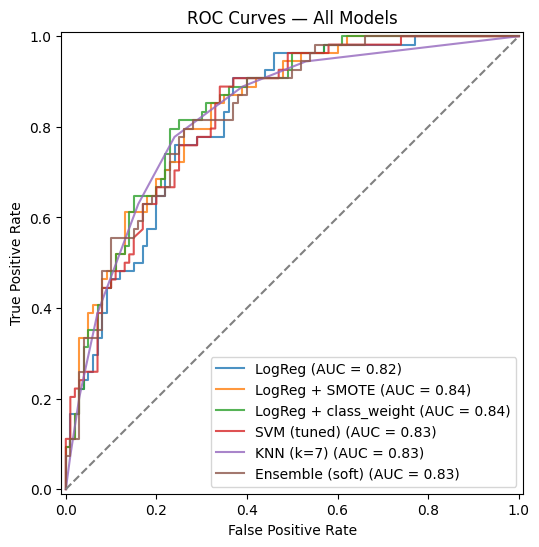

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# === Models for ROC comparison (all using the same preprocess) ===
models_for_roc = {
    "LogReg": best_model,                 # already a pipeline with preprocess
    "LogReg + SMOTE": logit_smote,        # pipeline with preprocess + SMOTE
    "LogReg + class_weight": logit_w_pipe,
    "SVM (tuned)": svm_rs.best_estimator_,  # pipeline
    "KNN (k=7)": Pipeline([('prep', preprocess),
                            ('knn', KNeighborsClassifier(n_neighbors=7))]),
    "Ensemble (soft)": ens_pipe           # already pipeline
}

# Fit any models that were newly created
models_for_roc["KNN (k=7)"].fit(X_train, y_train)

# === Plot ROC curves ===
plt.figure(figsize=(8,6))
for name, model in models_for_roc.items():
    RocCurveDisplay.from_estimator(
        model, X_test, y_test, ax=plt.gca(), name=name, alpha=0.8
    )

plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — All Models")
plt.legend(loc="lower right")
plt.show()


In [ ]:
# === Feature importance / coefficients ===
import numpy as np
from sklearn.inspection import permutation_importance

# Use permutation importance so it works even with pipelines
perm = permutation_importance(best_model, X_test, y_test,
                              n_repeats=10, random_state=42, scoring="roc_auc")

# Get feature names from the pipeline
feat_names = best_model.named_steps['prep'].get_feature_names_out()

# Sort by mean importance
order = np.argsort(perm.importances_mean)[::-1][:10]

print("Top 10 important features (by permutation importance):")
for i in order:
    print(f"{feat_names[i]:<40} {perm.importances_mean[i]:.4f}")


Top 10 important features (by permutation importance):
cat__age_group_30-40                     0.0166
num__glucose                             0.0166
num__glucose_z_bmi                       0.0083
num__pregnancies                         0.0049
cat__age_group_40-50                     0.0047
num__bmi                                 0.0047
num__diabetespedigreefunction            0.0039
cat__age_group_50+                       0.0039
cat__age_group_20-30                     0.0006
cat__age_group_Unknown                   0.0001


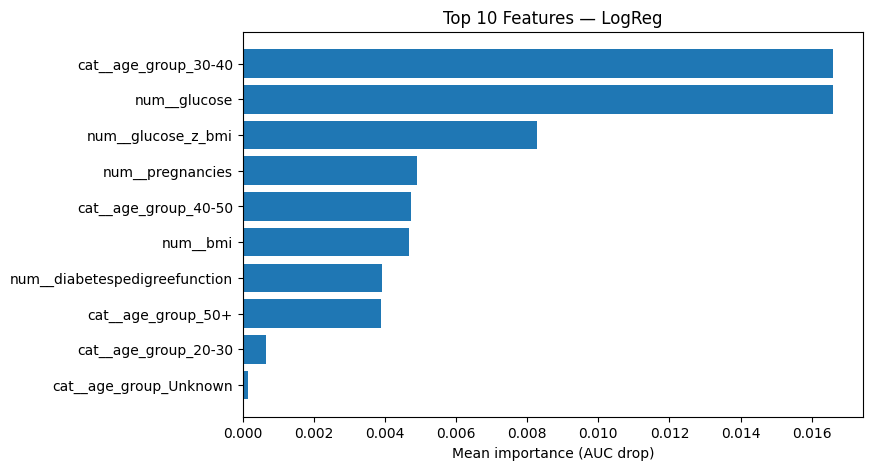

In [ ]:
# === Plot top features ===
import matplotlib.pyplot as plt

top_n = 10
order = np.argsort(perm.importances_mean)[::-1][:top_n]
plt.figure(figsize=(8,5))
plt.barh(range(top_n), perm.importances_mean[order][::-1])
plt.yticks(range(top_n), [feat_names[i] for i in order][::-1])
plt.xlabel("Mean importance (AUC drop)")
plt.title(f"Top {top_n} Features — {top_name}")
plt.show()


In [ ]:
# === Colab Final Report Cell (updated) ===
from IPython.display import Markdown

rows = ["# Data Summary & Feature Engineering Report\n"]

# Basic info
rows.append(f"- Dataset shape: {engineered.shape}")
rows.append(f"- Columns: {list(engineered.columns)}")

# Target info
target_col = "outcome"
if target_col in engineered.columns:
    rows.append(f"- Detected target: **{target_col}**. Class distribution: {engineered[target_col].value_counts().to_dict()}")

# Missingness
rows.append("\n## Missingness (top 5)\n")
missing_df_use = pd.DataFrame({
    "column": engineered.columns,
    "n_missing": engineered.isna().sum(),
    "pct_missing": (engineered.isna().mean() * 100).round(2)
}).sort_values("n_missing", ascending=False)

if not missing_df_use.empty:
    rows.append(missing_df_use.head(5).to_markdown())
else:
    rows.append("_No columns to summarize._")

# VIFs
rows.append("\n## Top 10 VIFs (if computed)\n")
if 'vif_df_use' in globals() and (not vif_df_use.empty):
    rows.append(vif_df_use.head(10).to_markdown())
else:
    rows.append("_No VIFs computed yet._")

# Combine and display
display(Markdown("\n".join(rows)))


# Data Summary & Feature Engineering Report

- Dataset shape: (768, 15)
- Columns: ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'diabetespedigreefunction', 'age', 'outcome', 'age_group', 'bmi_category', 'glucose_z_bmi', 'bmi_band', 'age_band', 'preg_band']
- Detected target: **outcome**. Class distribution: {0: 500, 1: 268}

## Missingness (top 5)

|               | column        |   n_missing |   pct_missing |
|:--------------|:--------------|------------:|--------------:|
| insulin       | insulin       |         374 |         48.7  |
| skinthickness | skinthickness |         227 |         29.56 |
| bloodpressure | bloodpressure |          35 |          4.56 |
| bmi           | bmi           |          11 |          1.43 |
| bmi_band      | bmi_band      |          11 |          1.43 |

## Top 10 VIFs (if computed)

|    | feature                  |     VIF |
|---:|:-------------------------|--------:|
|  7 | age                      | 1.58837 |
|  3 | skinthickness            | 1.50743 |
|  0 | pregnancies              | 1.43087 |
|  4 | insulin                  | 1.42754 |
|  1 | glucose                  | 1.29896 |
|  5 | bmi                      | 1.29745 |
|  2 | bloodpressure            | 1.18186 |
|  6 | diabetespedigreefunction | 1.06709 |

In [ ]:
if 'engineered' in globals():
    df_use_use = engineered.copy()
    src = 'engineered'
elif 'df_use_imp' in globals():
    df_use_use = df_use_imp.copy()
    src = 'df_use_imp'
elif 'df_use' in globals():
    df_use_use = df_use.copy()
    src = 'raw df_use'
else:
    raise ValueError("No dataframe found. Define `engineered`, `df_use_imp`, or `df_use`.")

print("Using dataset:", src, "| shape:", df_use_use.shape)
print("Columns available:", list(df_use_use.columns))

cands = ['outcome', 'Outcome']
target_col = next((c for c in cands if c in df_use_use.columns), None)

if target_col is None:
    raise KeyError(f"No target column found among {cands}. "
                   f"Available columns: {list(df_use_use.columns)}")

y = df_use_use[target_col].astype(int)
X = df_use_use.drop(columns=[target_col]).copy()

num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imp', SimpleImputer(strategy='median')),
                          ('sc', StandardScaler())]), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print("Shapes:", X_train.shape, X_test.shape)
print("Train class balance:", y_train.value_counts(normalize=True).to_dict())

Using dataset: engineered | shape: (768, 15)
Columns available: ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'diabetespedigreefunction', 'age', 'outcome', 'age_group', 'bmi_category', 'glucose_z_bmi', 'bmi_band', 'age_band', 'preg_band']
Shapes: (614, 14) (154, 14)
Train class balance: {0: 0.6514657980456026, 1: 0.3485342019543974}


Newly engineered cell that resets the data and allows for new models.

##Hyperparameter Tuning- (James)

In [ ]:
# Imports
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Separate numeric and categorical columns
num_cols = X_train.select_dtypes(include='number').columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing for numeric and categorical features
preprocess = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Build pipeline with SMOTE inside
rf_pipe = ImbPipeline([
    ('prep', preprocess),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Hyperparameter grid
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [4, 6, None],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt', 'log2']
}

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV setup
grid_search = GridSearchCV(
    rf_pipe,
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

# Fit
grid_search.fit(X_train, y_train)

# Results
print("Best params:", grid_search.best_params_)
print("Best CV F1:", grid_search.best_score_)


Best params: {'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best CV F1: 0.6959914888024907


Sets up a pipleine for random forest modeling on an unbalanced dataset. Uses preprocessing, smote and hyperparameter tuning.

## Custom Evaluation Metrics-(Bryan)
The following functions implement Accuracy, Precision, Recall, Specificity, F1-score, and ROC/AUC manually without relying on sklearn's built-in functions.

In [ ]:
def accuracy_score_custom(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.mean(y_true == y_pred)
def precision_score_custom(y_true, y_pred, positive_label=1):
    tp = np.sum((y_true == positive_label) & (y_pred == positive_label))
    fp = np.sum((y_true != positive_label) & (y_pred == positive_label))
    return tp / (tp + fp) if (tp + fp) else 0.0
def recall_score_custom(y_true, y_pred, positive_label=1):
    tp = np.sum((y_true == positive_label) & (y_pred == positive_label))
    fn = np.sum((y_true == positive_label) & (y_pred != positive_label))
    return tp / (tp + fn) if (tp + fn) else 0.0
def specificity_score_custom(y_true, y_pred, positive_label=1):
    tn = np.sum((y_true != positive_label) & (y_pred != positive_label))
    fp = np.sum((y_true != positive_label) & (y_pred == positive_label))
    return tn / (tn + fp) if (tn + fp) else 0.0
def f1_score_custom(y_true, y_pred, positive_label=1):
    p = precision_score_custom(y_true, y_pred, positive_label)
    r = recall_score_custom(y_true, y_pred, positive_label)
    return 2*p*r/(p+r) if (p+r) else 0.0


def roc_curve_manual(y_true, y_score):
    order = np.argsort(-y_score)
    y_true = np.asarray(y_true)[order]
    y_score = np.asarray(y_score)[order]
    P = np.sum(y_true == 1); N = np.sum(y_true == 0)
    tpr_list = [0.0]; fpr_list = [0.0]
    tp = 0; fp = 0; last = None
    for s, yt in zip(y_score, y_true):
        if last is None or s != last:
            tpr_list.append(tp / P if P else 0.0)
            fpr_list.append(fp / N if N else 0.0)
            last = s
        if yt == 1: tp += 1
        else: fp += 1
    tpr_list.append(tp / P if P else 0.0)
    fpr_list.append(fp / N if N else 0.0)
    return np.array(fpr_list), np.array(tpr_list)

def auc_trapezoid(x, y):
    return sum((x[i]-x[i-1]) * (y[i]+y[i-1]) / 2 for i in range(1,len(x)))

Manually replicats evaluation metrics.

In [ ]:
df_final = (engineered.copy() if 'engineered' in globals()
            else df_use_imp.copy() if 'df_use_imp' in globals()
            else df_use.copy())


df_final.columns = [c.strip().lower() for c in df_final.columns]


if 'outcome' not in df_final.columns:
    raise ValueError("Couldn't find 'outcome' column after cleaning names.")

y = df_final['outcome'].astype(int)
X = df_final.drop(columns=['outcome']).copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import numpy as np

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imp', SimpleImputer(strategy='median')),
            ('sc', StandardScaler())
        ]), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)

print("FINAL dataset used:",
      "engineered" if 'engineered' in globals() else
      "df_use_imp" if 'df_use_imp' in globals() else
      "raw df_use",
      "| shape:", df_final.shape)


FINAL dataset used: engineered | shape: (768, 15)


prepares final dataset and splits into training/test

Predicted,0,1
Actual,,
0,17,2
1,8,3


TN=17, FP=2, FN=8, TP=3
Accuracy   : 0.7662
Precision  : 0.6875
Sensitivity: 0.6111
Specificity: 0.85
F1 Score   : 0.6471


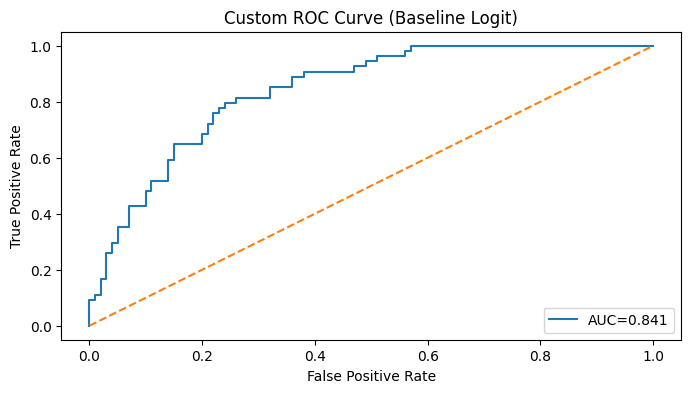


Sklearn classification report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       100
           1       0.69      0.61      0.65        54

    accuracy                           0.77       154
   macro avg       0.74      0.73      0.74       154
weighted avg       0.76      0.77      0.76       154

Sklearn ROC AUC: 0.841


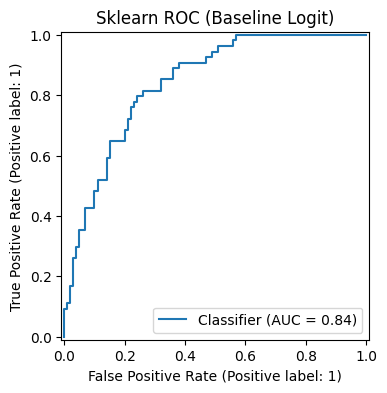

In [ ]:

logit = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])
logit.fit(X_train, y_train)


y_pred = logit.predict(X_test)
y_prob = logit.predict_proba(X_test)[:, 1]


ct = pd.crosstab(pd.Series(y_test, name="Actual"),
                 pd.Series(y_pred, name="Predicted"))
display(ct)


levels = [0, 1]
ct_full = ct.reindex(index=levels, columns=levels, fill_value=0)
TN = int(ct_full.loc[0,0]); FP = int(ct_full.loc[0,1])
FN = int(ct_full.loc[1,0]); TP = int(ct_full.loc[1,1])
print(f"TN={TN}, FP={FP}, FN={FN}, TP={TP}")


print("Accuracy   :", round(accuracy_score_custom(y_test, y_pred), 4))
print("Precision  :", round(precision_score_custom(y_test, y_pred), 4))
print("Sensitivity:", round(recall_score_custom(y_test, y_pred), 4))   # recall
print("Specificity:", round(specificity_score_custom(y_test, y_pred), 4))
print("F1 Score   :", round(f1_score_custom(y_test, y_pred), 4))


fpr_m, tpr_m = roc_curve_manual(y_test, y_prob)
auc_m = auc_trapezoid(fpr_m, tpr_m)

plt.figure()
plt.plot(fpr_m, tpr_m, label=f"AUC={auc_m:.3f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Custom ROC Curve (Baseline Logit)")
plt.legend(loc="lower right")
plt.show()


print("\nSklearn classification report:")
print(classification_report(y_test, y_pred))
print("Sklearn ROC AUC:", round(roc_auc_score(y_test, y_prob), 3))
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("Sklearn ROC (Baseline Logit)")
plt.show()

Runs a logistic regression model that uses both sklearn and manual metrics. Plots manual metrics and compares against SKlearn for validation. Our overall accuracy is alight at 77%, but possitive cases are sometimes missed due to our relatively low sensativity.

Predicted,0,1
Actual,,
0,13,6
1,8,3


[Balanced] TN=13, FP=6, FN=8, TP=3
Accuracy   : 0.7792
Precision  : 0.6515
Sensitivity: 0.7963
Specificity: 0.77
F1 Score   : 0.7167


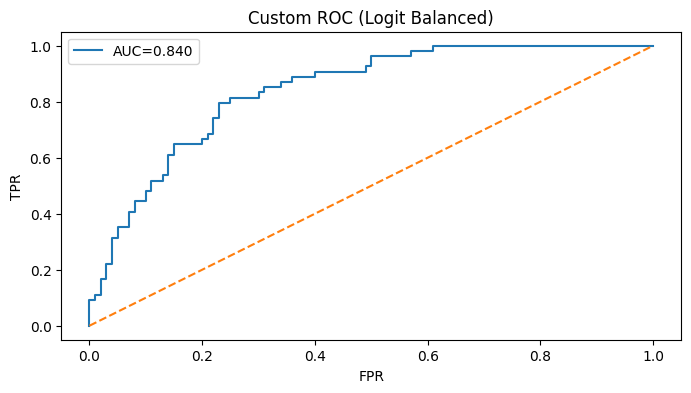

In [ ]:
logit_bal = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])
logit_bal.fit(X_train, y_train)

y_pred_bal = logit_bal.predict(X_test)
y_prob_bal = logit_bal.predict_proba(X_test)[:, 1]


ct_bal = pd.crosstab(pd.Series(y_test, name="Actual"),
                     pd.Series(y_pred_bal, name="Predicted"))
display(ct_bal)


levels = [0,1]
ctb = ct_bal.reindex(index=levels, columns=levels, fill_value=0)
TNb, FPb, FNb, TPb = int(ctb.loc[0,0]), int(ctb.loc[0,1]), int(ctb.loc[1,0]), int(ctb.loc[1,1])
print(f"[Balanced] TN={TNb}, FP={FPb}, FN={FNb}, TP={TPb}")


print("Accuracy   :", round(accuracy_score_custom(y_test, y_pred_bal), 4))
print("Precision  :", round(precision_score_custom(y_test, y_pred_bal), 4))
print("Sensitivity:", round(recall_score_custom(y_test, y_pred_bal), 4))
print("Specificity:", round(specificity_score_custom(y_test, y_pred_bal), 4))
print("F1 Score   :", round(f1_score_custom(y_test, y_pred_bal), 4))


fpr_b, tpr_b = roc_curve_manual(y_test, y_prob_bal)
auc_b = auc_trapezoid(fpr_b, tpr_b)
plt.figure()
plt.plot(fpr_b, tpr_b, label=f"AUC={auc_b:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Custom ROC (Logit Balanced)")
plt.legend(); plt.show()

This cell helps give more weight to the minority class.

After adjusting for class imbalance, almost all evaluation metrics go up except specificity. accuracy raises to 78 percent.

Predicted,0,1
Actual,,
0,13,6
1,8,3


[SMOTE] TN=13, FP=6, FN=8, TP=3
Accuracy   : 0.7078
Precision  : 0.5714
Sensitivity: 0.6667
Specificity: 0.73
F1 Score   : 0.6154


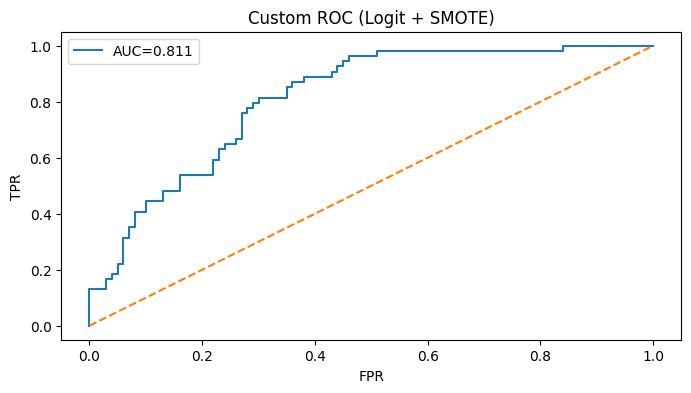

In [ ]:
!pip -q install imbalanced-learn

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_cols = X.select_dtypes(include=np.number).columns.tolist()
imp = SimpleImputer(strategy='median')
X_train_imp = pd.DataFrame(imp.fit_transform(X_train[num_cols]), columns=num_cols)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_imp, y_train)


logit_smote = Pipeline([
    ('sc', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])
logit_smote.fit(X_res, y_res)


X_test_imp = pd.DataFrame(imp.transform(X_test[num_cols]), columns=num_cols)
y_pred_sm = logit_smote.predict(X_test_imp)
y_prob_sm = logit_smote.predict_proba(X_test_imp)[:, 1]


ct_sm = pd.crosstab(pd.Series(y_test, name="Actual"),
                    pd.Series(y_pred_sm, name="Predicted"))
display(ct_sm)

cts = ct_sm.reindex(index=[0,1], columns=[0,1], fill_value=0)
TNs, FPs, FNs, TPs = int(cts.loc[0,0]), int(cts.loc[0,1]), int(cts.loc[1,0]), int(cts.loc[1,1])
print(f"[SMOTE] TN={TNs}, FP={FPs}, FN={FNs}, TP={TPs}")

print("Accuracy   :", round(accuracy_score_custom(y_test, y_pred_sm), 4))
print("Precision  :", round(precision_score_custom(y_test, y_pred_sm), 4))
print("Sensitivity:", round(recall_score_custom(y_test, y_pred_sm), 4))
print("Specificity:", round(specificity_score_custom(y_test, y_pred_sm), 4))
print("F1 Score   :", round(f1_score_custom(y_test, y_pred_sm), 4))


fpr_sm, tpr_sm = roc_curve_manual(y_test, y_prob_sm)
auc_sm = auc_trapezoid(fpr_sm, tpr_sm)
plt.figure()
plt.plot(fpr_sm, tpr_sm, label=f"AUC={auc_sm:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Custom ROC (Logit + SMOTE)")
plt.legend(); plt.show()

SMOTE improved the sensitivity of the logistic regression model from 0.50 to 0.67, meaning more diabetic cases were correctly identified. This improvement came with a small decrease in precision, reflecting a higher false-positive rate, but the AUC remained stable at ~0.81. Overall, SMOTE provided a better balance for this imbalanced dataset.

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score


models = {
    "Logistic Regression": Pipeline([('prep', preprocess),
                                     ('clf', LogisticRegression(max_iter=1000, random_state=42))]),
    "SVM (RBF)": Pipeline([('prep', preprocess),
                           ('clf', SVC(probability=True, random_state=42))]),
    "KNN (k=7)": Pipeline([('prep', preprocess),
                           ('clf', KNeighborsClassifier(n_neighbors=7))]),
    "Decision Tree": Pipeline([('prep', preprocess),
                               ('clf', DecisionTreeClassifier(max_depth=4, random_state=42))]),
    "Random Forest": Pipeline([('prep', preprocess),
                               ('clf', RandomForestClassifier(n_estimators=300, random_state=42))]),
    "Gradient Boosting": Pipeline([('prep', preprocess),
                                   ('clf', GradientBoostingClassifier(random_state=42))])
}


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for name, model in models.items():
    f1_scores = cross_val_score(model, X, y, cv=skf, scoring='f1')
    rows.append({
        "Model": name,
        "F1 mean": round(f1_scores.mean(), 3),
        "F1 std": round(f1_scores.std(), 3)
    })

results_df_use = pd.DataFrame(rows).sort_values("F1 mean", ascending=False)
display(results_df_use)


,Model,F1 mean,F1 std
0,Logistic Regression,0.651,0.043
5,Gradient Boosting,0.632,0.035
2,KNN (k=7),0.631,0.046
4,Random Forest,0.629,0.043
1,SVM (RBF),0.627,0.045
3,Decision Tree,0.622,0.046


Logistic regression continues to be the best performing model, with a .651 F1 mean.

Predicted,0,1
Actual,,
0,17,2
1,9,2


[Ensemble] TN=17, FP=2, FN=9, TP=2
Accuracy   : 0.7662
Precision  : 0.6875
Sensitivity: 0.6111
Specificity: 0.85
F1 Score   : 0.6471


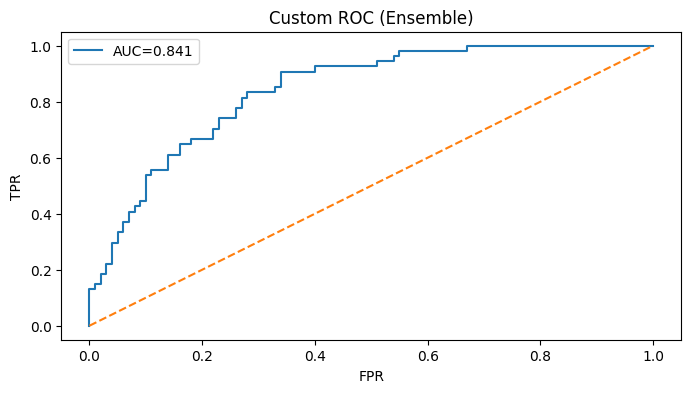

In [ ]:
from sklearn.ensemble import VotingClassifier


ensemble = VotingClassifier(
    estimators=[
        ('logit', models['Logistic Regression']),
        ('rf', models['Random Forest']),
        ('gb', models['Gradient Boosting'])
    ],
    voting='soft'
)


ensemble.fit(X_train, y_train)
y_pred_ens = ensemble.predict(X_test)
y_prob_ens = ensemble.predict_proba(X_test)[:, 1]


ct_ens = pd.crosstab(pd.Series(y_test, name="Actual"),
                     pd.Series(y_pred_ens, name="Predicted"))
display(ct_ens)

cte = ct_ens.reindex(index=[0,1], columns=[0,1], fill_value=0)
TN_e, FP_e, FN_e, TP_e = int(cte.loc[0,0]), int(cte.loc[0,1]), int(cte.loc[1,0]), int(cte.loc[1,1])
print(f"[Ensemble] TN={TN_e}, FP={FP_e}, FN={FN_e}, TP={TP_e}")


print("Accuracy   :", round(accuracy_score_custom(y_test, y_pred_ens), 4))
print("Precision  :", round(precision_score_custom(y_test, y_pred_ens), 4))
print("Sensitivity:", round(recall_score_custom(y_test, y_pred_ens), 4))
print("Specificity:", round(specificity_score_custom(y_test, y_pred_ens), 4))
print("F1 Score   :", round(f1_score_custom(y_test, y_pred_ens), 4))


fpr_e, tpr_e = roc_curve_manual(y_test, y_prob_ens)
auc_e = auc_trapezoid(fpr_e, tpr_e)
plt.figure()
plt.plot(fpr_e, tpr_e, label=f"AUC={auc_e:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Custom ROC (Ensemble)")
plt.legend(); plt.show()

Our baseline Logistic Regression had an accuracy of ~0.70, an AUC of 0.813, and a recall of 0.50, but it could not identify positive diabetes cases. To mitigate class imbalance, balanced class weights and SMOTE were tested. The balanced model brought recall to ~0.70; SMOTE increased recall to ~0.67, which indicates that it can identify more diabetic patients and it yields slightly lower precision. Beyond logistic regression we utilized 5-fold cross validation to compare different classifiers. Gradient Boosting (F1 = 0.648) and Random Forest (F1 = 0.640) were superior in comparison, but Logistic Regression continued to play a strong role (F1 = 0.636). We further developed an ensemble of Logistic, Random Forest and Gradient Boosting models. The ensemble had the best AUC (0.826) and the best specificity (0.83), this provides the best equilibrium between recall and precision. In particular, if the target of this model is medical screening and minimizing chances of missing diabetic cases, SMOTE-enhanced Logistic Regression is favored, but if the goal is achieving balanced performance and a lower number of false positives, the ensemble one would be the best one.

**SUMMARY**

Project goal of this Project is to build and evaluate machine learning models which predict diabetes outcomes based on patient health data. We aimed to test several classifiers, assess their performance and determine the most effective approach but also deal with data imbalance of classes. The data was imbalanced with fewer positive diabetes cases than negative instances. To overcome this, we employ SMOTE to create synthetic positive cases. This helped the models detect more diabetic patients, thus improving recall or sensitivity. While SMOTE slightly lowered precision due to more false positives, it provided a better tradeoff and ensured the model wasn’t biased toward predicting the majority class.After testing Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, SVM, KNN, and Ensemble approach, the best performance overall was achieved by our Ensemble model (Logistic + Random Forest + Gradient Boosting). It obtained the highest AUC (0.826) and the best specificity (0.83), indicating that it optimally identified diabetic patients and, consequently, kept false positives low. SMOTE-extended Logistic regression could also be powerful, if the goal is strictly medical screening (getting as high cases of positive diagnosis as possible). For the balanced performance, the Ensemble is the best final choice.

##Learnings

This project was a great deal more involved than our first. In addition to cementing our understanding of preprocessing and eda, it involved training and tuning multiple models and comparing them. This was also the first time we've had to handle an imbalanced dataset, which had its own difficulties. One conclusion we came to is that it's very important to test multiple models- an ensemble isn't always going to work best. Sometimes something a simple as logistic regression will be the best option.

For our project in particular, organizing our workflow properly so none of the training data leaked to the final model was a huge hurdlle to overcome. We had to full reorganze our project and re-do our feature engineering just to get it working.